# MSCA 32018 Natural Language Processing and Cognitive Computing
## Final Project - Topic Modelling

Shijia Huang

-----

In [1]:
# Import basic libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
# Import NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pprint import pprint
import string
from rake_nltk import Rake

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
spacy.prefer_gpu()
print(spacy.__version__)

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim as gensimvis
#import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

3.5.2


In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [4]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


### Read Cleaned New Articles

In [5]:
%%time

# GCP version
path = "gs://nlp-final-project-data/data/"
df_news = pd.read_parquet(path + 'news_filtered.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 32s, sys: 43.7 s, total: 2min 16s
Wall time: 7min 16s


(154283, 10)

In [6]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154283 entries, 0 to 154282
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154283 non-null  int64 
 1   date              154283 non-null  object
 2   cleaned title     154283 non-null  object
 3   cleaned text      154283 non-null  object
 4   title_tokens      154283 non-null  object
 5   title_lemmatized  154283 non-null  object
 6   text_tokens       154283 non-null  object
 7   text_lemmatized   154283 non-null  object
 8   title_keywords    154283 non-null  object
 9   text_keywords     154283 non-null  object
dtypes: int64(1), object(9)
memory usage: 11.8+ MB


In [7]:
df_news.head(2)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords
0,1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai_robot]","[child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, ai_robot]","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, admin, latest, posts, admin, see, mansplaining, conferences, get, forestall, february, coronavirus, could, explode, overnight, like, italy, february, levi, strauss, marks, next, phase, corporate, paid, leave, policies, february, scientists, designed, artificially, clever, robotic, helped, youngsters, autism, spice, studying, social, talents, hope, era, may, future, help, others, developmental, dysfunction, learn, ...","[child, autism, see, learn, social, skill, boost, play, robot, late, post, admin, see, mansplaining, conference, get, explode, overnight, mark, next, phase, corporate, pay, leave, policy, scientist, design, artificially, clever, robotic, help, youngster, autism, spice, study, social, talent, era, future, help, other, developmental, dysfunction, learn, notice, youngster, gentle, average, autism, take, domestic, s, refer, socially, assistive, robotic, name, kiwi, month, accord, commentary, way...","[social, skill, see, play, learn, child, boost, autism, robot, ai_robot]","[robotic, youngster, kid, child, kiwi, market, autism, learn, crew, talent]"
1,2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus","Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, world, entered, new, era, accelerated, transformation, last, eighteen, months, continue, evolve, press, forward, years, come, businesses, playing, catchup, trying, make, sense, new, timeline, ten, years, set, aside, careful, planning, implementation, coming, next, longer, exists, next, happening, regardless, industry, seniority, status, quo, shifted, better, face, back, invited, attend, pompous, meeting, london, brazilian, embassy, along, selec...","[forget, ai, industry, obsolescence, focus, world, enter, new, era, accelerate, transformation, last, month, continue, evolve, press, forward, year, come, business, play, catchup, try, make, sense, new, timeline, year, set, aside, careful, planning, implementation, come, next, long, exist, next, happen, 

In [8]:
### SAMPLE DATA
df_news = df_news.sample(frac=0.01, random_state=42)
df_news.shape

(1543, 10)

## 1. Topic Modeling - LDA

In [9]:
%%time

# Create term dictionary
text_lemmatized = df_news['text_lemmatized'].tolist()
text_dict = corpora.Dictionary(text_lemmatized)

# Convert list of documents (corpus) into Document Term Matrix using dictionary prepared above
text_doc_term_matrix = [text_dict.doc2bow(doc) for doc in text_lemmatized]

CPU times: user 2.03 s, sys: 956 ms, total: 2.98 s
Wall time: 3.88 s


### Initial Model - 10 Topics

In [10]:
%%time

# Build LDA model for news text
lda_model_text = LdaMulticore(corpus=text_doc_term_matrix,
                              id2word=text_dict,
                              num_topics=10,
                              random_state=100,
                              passes=10,
                              alpha='asymmetric',
                              eta='auto',
                              workers=num_processors-1)

CPU times: user 1min 26s, sys: 27.7 s, total: 1min 53s
Wall time: 1min 1s


In [11]:
# print the topics
pprint(lda_model_text.print_topics())

[(0,
  '0.010*"ai" + 0.009*"trade" + 0.009*"use" + 0.007*"dollar" + 0.005*"machine" '
  '+ 0.005*"say" + 0.004*"model" + 0.004*"datum" + 0.004*"learn" + '
  '0.004*"company"'),
 (1,
  '0.008*"market" + 0.007*"datum" + 0.006*"company" + 0.006*"stock" + '
  '0.006*"ai" + 0.005*"share" + 0.004*"intelligence" + 0.004*"say" + '
  '0.004*"technology" + 0.003*"new"'),
 (2,
  '0.070*"market" + 0.020*"report" + 0.016*"analysis" + 0.014*"global" + '
  '0.013*"industry" + 0.013*"ai" + 0.012*"growth" + 0.011*"forecast" + '
  '0.011*"intelligence" + 0.008*"research"'),
 (3,
  '0.011*"ai" + 0.010*"use" + 0.009*"say" + 0.008*"technology" + '
  '0.005*"company" + 0.005*"new" + 0.004*"datum" + 0.004*"also" + 0.004*"make" '
  '+ 0.004*"work"'),
 (4,
  '0.008*"ai" + 0.006*"company" + 0.005*"say" + 0.004*"quote" + '
  '0.004*"chatgpt" + 0.004*"use" + 0.004*"new" + 0.003*"user" + '
  '0.003*"technology" + 0.003*"also"'),
 (5,
  '0.009*"use" + 0.008*"say" + 0.008*"ai" + 0.005*"technology" + '
  '0.005*"syst

In [12]:
# Compute Coherence Score
coherence_model_lda_text = CoherenceModel(model=lda_model_text, texts=text_lemmatized, dictionary=text_dict, coherence='c_v')

coherence_lda_text = coherence_model_lda_text.get_coherence()
print('\nCoherence Score: ', coherence_lda_text)


Coherence Score:  0.3347979245710021


### Hyperparameter Tuning

- Number of Topics (K)
- Dirichlet hyperparameter alpha: Asymmetric
- Dirichlet hyperparameter beta: Auto

In [36]:
# supporting function
def compute_coherence_values(corpus, dictionary, texts, k):

    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=k,
                             random_state=100,
                             passes=10,
                             alpha='asymmetric',
                             eta='auto',
                             workers=num_processors-1)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [37]:
%%time

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Validation sets
num_of_docs = len(text_doc_term_matrix)
corpus_sets = [text_doc_term_matrix]
corpus_title = ['100% Corpus']
model_results = {'Topics': [], 'Coherence': []}

itr = 0
itr_total = len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

# iterate through validation corpuses
for i in range(len(corpus_sets)):
    
    # iterate through number of topics
    for k in topics_range:

        cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=text_dict, texts=text_lemmatized, k=k)
        
        model_results['Topics'].append(k)
        model_results['Coherence'].append(cv)
        
        itr += 1

        pct_completed = round((itr / itr_total * 100), 1)
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')

LDA will execute 19 iterations
Completed model based on 2 LDA topics. Finished 5.3% of LDA runs


KeyboardInterrupt: 

In [38]:
text_lda_tuning = pd.DataFrame(model_results)
path_result = 'gs://nlp-final-project-data/result/'
text_lda_tuning.to_csv(path_result + 'text_lda_tuning_results.csv', index=False)

In [39]:
# Best LDA parameters
text_lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Coherence
0,2,0.394838


In [40]:
# Worst LDA parameters
text_lda_tuning.sort_values(by=['Coherence']).head(10)

,Topics,Coherence
0,2,0.394838


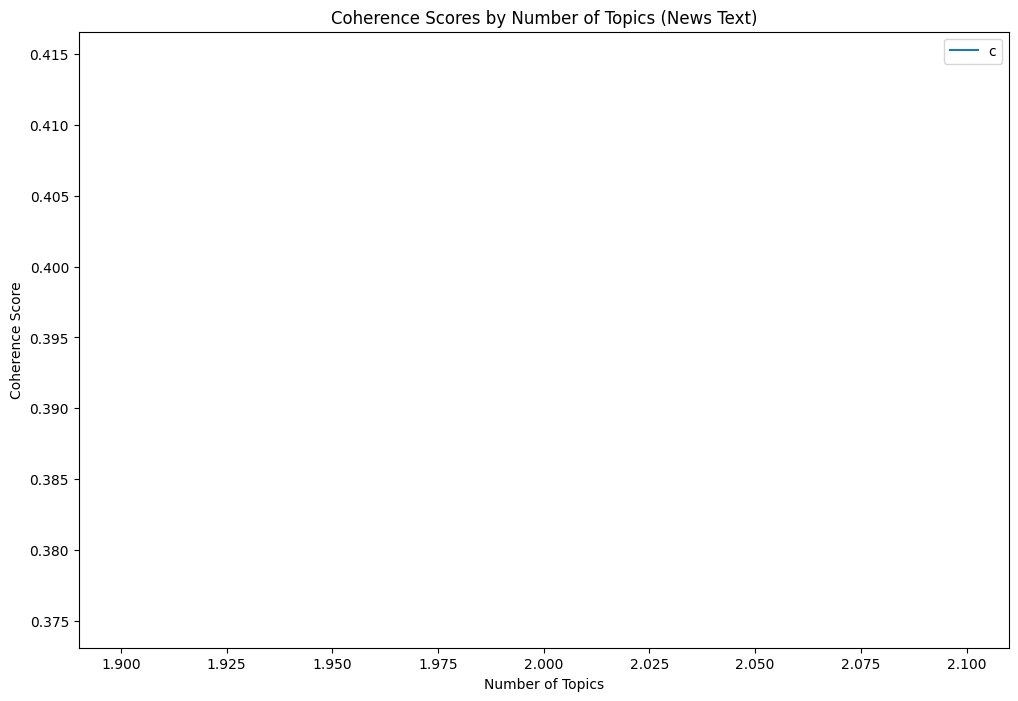

In [41]:
# plot the coherence scores
plt.figure(figsize=(12, 8))
plt.plot(text_lda_tuning['Topics'], text_lda_tuning['Coherence'])
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores by Number of Topics (News Text)')
plt.legend(('coherence_values'), loc='best')
plt.show()

### Runnning Best Model

In [42]:
text_lda_tuning_best = text_lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)

text_tuned_topics = int(text_lda_tuning_best['Topics'].to_string(index=False))

print(f'Best number of topics for news text: {text_tuned_topics}')

Best number of topics for news text: 2


In [33]:
%%time

# Build LDA model for news text
lda_model_text_tuned = LdaMulticore(corpus=text_doc_term_matrix,
                                    id2word=text_dict,
                                    num_topics=text_tuned_topics,
                                    random_state=100,
                                    passes=10,
                                    alpha=tuned_alpha,
                                    eta=tuned_beta,
                                    workers=num_processors-1)

coherence_lda_text_tuned = CoherenceModel(model=lda_model_text_tuned, texts=text_lemmatized, dictionary=text_dict, coherence='c_v').get_coherence()

print('\nCoherence Score: ', coherence_lda_text_tuned)


Coherence Score:  0.4159349694728773
CPU times: user 34.8 s, sys: 3.36 s, total: 38.2 s
Wall time: 1min 18s


In [34]:
%%time

lda_display_text_tuned = pyLDAvis.gensim.prepare(lda_model_text_tuned, text_doc_term_matrix, text_dict, sort_topics=False, mds='mmds')

pyLDAvis.display(lda_display_text_tuned)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated


CPU times: user 1.62 s, sys: 842 ms, total: 2.46 s
Wall time: 6.59 s


## Clustering

## Classification

## Zero-shot Modeling